In [517]:
from collections import defaultdict
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, precision_recall_curve, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [518]:
engagement = pd.read_csv('takehome_user_engagement.csv')

In [519]:
print (engagement.head())

            time_stamp  user_id  visited
0  2014-04-22 03:53:30        1        1
1  2013-11-15 03:45:04        2        1
2  2013-11-29 03:45:04        2        1
3  2013-12-09 03:45:04        2        1
4  2013-12-25 03:45:04        2        1


In [520]:
print(engagement.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


In [521]:
print(engagement.isnull().sum())

time_stamp    0
user_id       0
visited       0
dtype: int64


In [522]:
print(engagement.duplicated().sum())

0


In [523]:
print(engagement.dtypes)

time_stamp    object
user_id        int64
visited        int64
dtype: object


In [524]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [525]:
print(engagement['time_stamp'].unique())

<DatetimeArray>
['2014-04-22 03:53:30', '2013-11-15 03:45:04', '2013-11-29 03:45:04',
 '2013-12-09 03:45:04', '2013-12-25 03:45:04', '2013-12-31 03:45:04',
 '2014-01-08 03:45:04', '2014-02-03 03:45:04', '2014-02-08 03:45:04',
 '2014-02-09 03:45:04',
 ...
 '2014-04-28 14:22:45', '2014-05-17 14:22:45', '2014-05-30 14:22:45',
 '2014-04-11 19:39:56', '2013-10-22 13:33:17', '2013-09-06 06:14:15',
 '2013-01-15 18:28:37', '2014-04-27 12:45:16', '2012-06-02 11:55:59',
 '2014-01-26 08:57:12']
Length: 207220, dtype: datetime64[ns]


In [526]:
print(engagement['user_id'].unique())

[    1     2     3 ... 11998 11999 12000]


In [527]:
print(engagement['visited'].unique())

[1]


<Axes: xlabel='time_stamp'>

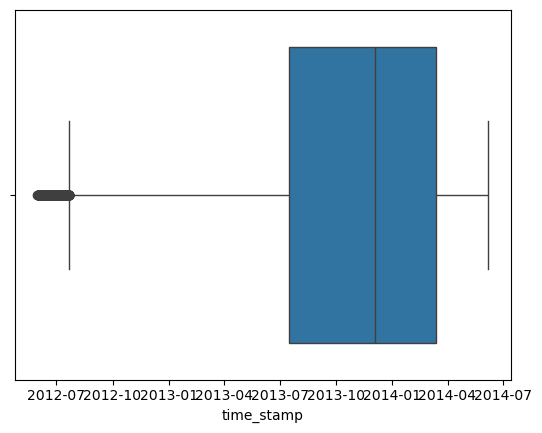

In [528]:
sns.boxplot(x=engagement['time_stamp'])

In [529]:
# Extract year from time_stamp
engagement['year'] = engagement['time_stamp'].dt.year

# Count the number of records per year
year_counts = engagement['year'].value_counts().sort_index()

print(year_counts)

year
2012     11855
2013    105725
2014     90337
Name: count, dtype: int64


##### The distribution of dates seemed odd, but I see what is happening now

In [530]:
#takehome = pd.read_csv('takehome_users.csv')   #something odd preventing this!
takehome = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1') 

In [531]:
print(takehome.head())

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   

In [532]:
print(takehome.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None


In [533]:
print(takehome.describe())

         object_id  last_session_creation_time  opted_in_to_mailing_list  \
count  12000.00000                8.823000e+03              12000.000000   
mean    6000.50000                1.379279e+09                  0.249500   
std     3464.24595                1.953116e+07                  0.432742   
min        1.00000                1.338452e+09                  0.000000   
25%     3000.75000                1.363195e+09                  0.000000   
50%     6000.50000                1.382888e+09                  0.000000   
75%     9000.25000                1.398443e+09                  0.000000   
max    12000.00000                1.402067e+09                  1.000000   

       enabled_for_marketing_drip        org_id  invited_by_user_id  
count                12000.000000  12000.000000         6417.000000  
mean                     0.149333    141.884583         5962.957145  
std                      0.356432    124.056723         3383.761968  
min                      0.000000  

In [534]:
print(takehome.isnull().sum())

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64


In [535]:
print(takehome.dtypes)

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object


In [536]:
takehome['name'] = takehome['name'].astype('string')
print(takehome['object_id'].unique())

[    1     2     3 ... 11998 11999 12000]


In [537]:
takehome['email'] = takehome['email'].astype('string')
print(takehome['email'].unique())

<StringArray>
[     'AugustCClausen@yahoo.com',        'MatthewPoole@gustr.com',
    'MitchellBottrill@gustr.com',     'NicklasSClausen@yahoo.com',
            'GraceRaw@yahoo.com', 'EduardoPereiraCunha@yahoo.com',
    'TylerSewell@jourrapide.com',    'DanielleHamilton@yahoo.com',
         'PaulAmsel@hotmail.com', 'CarlaFerreiraSantos@gustr.com',
 ...
       'ArthurJVaughn@gmail.com',    'AmandaAHermansen@yahoo.com',
       'IsabelTownsend@cuvox.de',            'conxzghp@eaouk.com',
     'SebastianWerfel@gmail.com',         'SophiaMeier@gustr.com',
        'AmelieFisher@gmail.com',           'JakeHaynes@cuvox.de',
            'mhaerzxp@iuxiw.com',     'ThaisMeloLima@hotmail.com']
Length: 11980, dtype: string


In [538]:
takehome['creation_source'] = takehome['creation_source'].astype('string')
print(takehome['creation_source'].unique())

<StringArray>
[      'GUEST_INVITE',         'ORG_INVITE',             'SIGNUP',
  'PERSONAL_PROJECTS', 'SIGNUP_GOOGLE_AUTH']
Length: 5, dtype: string


In [539]:
takehome['opted_in_to_mailing_list'] = takehome['opted_in_to_mailing_list'].astype('int')
print(takehome['opted_in_to_mailing_list'].unique())
#This was originally changed to boolean, but it was interfering with the analytics I did later.  I didn't want to clear the code block entirely, so I simply have it set as 'int' again as a reminder where this took place, should I need to change it to a boolean value later.

[1 0]


In [540]:
takehome['opted_in_to_mailing_list'] = takehome['opted_in_to_mailing_list'].astype('int')
print(takehome['opted_in_to_mailing_list'].unique())
#See above note

[1 0]


In [541]:
takehome['creation_time'] = pd.to_datetime(takehome['creation_time'])
print(takehome['creation_time'].unique())

<DatetimeArray>
['2014-04-22 03:53:30', '2013-11-15 03:45:04', '2013-03-19 23:14:52',
 '2013-05-21 08:09:28', '2013-01-17 10:14:20', '2013-12-17 03:37:06',
 '2012-12-16 13:24:32', '2013-07-31 05:34:02', '2013-11-05 04:04:24',
 '2013-01-16 22:08:03',
 ...
 '2014-04-20 14:22:45', '2014-04-09 19:39:56', '2013-03-28 23:24:21',
 '2012-06-05 04:46:16', '2013-10-21 13:33:17', '2013-09-06 06:14:15',
 '2013-01-10 18:28:37', '2014-04-27 12:45:16', '2012-05-31 11:55:59',
 '2014-01-26 08:57:12']
Length: 11996, dtype: datetime64[ns]


In [542]:
takehome['last_session_creation_time'] = pd.to_datetime(takehome['last_session_creation_time'], unit='s')

print(takehome['last_session_creation_time'].unique())

<DatetimeArray>
['2014-04-22 03:53:30', '2014-03-31 03:45:04', '2013-03-19 23:14:52',
 '2013-05-22 08:09:28', '2013-01-22 10:14:20', '2013-12-19 03:37:06',
 '2012-12-20 13:24:32',                 'NaT', '2014-06-03 22:08:03',
 '2013-12-27 03:55:54',
 ...
 '2013-09-07 11:24:33', '2013-07-06 21:00:48', '2014-05-30 14:22:45',
 '2014-04-11 19:39:56', '2013-10-22 13:33:17', '2013-09-06 06:14:15',
 '2013-01-15 18:28:37', '2014-04-27 12:45:16', '2012-06-02 11:55:59',
 '2014-01-26 08:57:12']
Length: 8822, dtype: datetime64[ns]


## The values for last_session_creation_time were in seconds, which have now been converted to a proper datetime value.

In [543]:
print(takehome.dtypes)

object_id                              int64
creation_time                 datetime64[ns]
name                          string[python]
email                         string[python]
creation_source               string[python]
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int32
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object


## Aside from the null values for the last_session_creation_time and invited_by_user_id, the data looks straightforward.

## I'll begin by labeling those who already qualify as "adopted"

In [544]:
adopted_user_ids = set()

for user_id, user_df in engagement.groupby('user_id'):
    dates = user_df['time_stamp'].dt.date.sort_values().unique()
    for i in range(len(dates) - 2):
        if (dates[i+2] - dates[i]).days <= 7:
            adopted_user_ids.add(user_id)
            break

In [545]:
takehome['adopted'] = takehome['object_id'].isin(adopted_user_ids).astype(int)

In [546]:
# Feature: was_invited
takehome['was_invited'] = takehome['invited_by_user_id'].notna().astype(int)

# Feature: account age (using the latest engagement timestamp as a reference)
max_engagement_date = engagement['time_stamp'].max()
takehome['account_age_days'] = (max_engagement_date - takehome['creation_time']).dt.days

# Feature: time to first activity
first_engagement = engagement.groupby('user_id')['time_stamp'].min()
takehome = takehome.merge(first_engagement.rename('first_engagement'), how='left', left_on='object_id', right_index=True)
takehome['activity_delay_days'] = (takehome['first_engagement'] - takehome['creation_time']).dt.days
takehome['activity_delay_days'] = takehome['activity_delay_days'].fillna(-1)  # -1 for users with no activity

# One-hot encode creation_source
takehome = pd.get_dummies(takehome, columns=['creation_source'], drop_first=True)

In [547]:
print(takehome.dtypes)

object_id                                      int64
creation_time                         datetime64[ns]
name                                  string[python]
email                                 string[python]
last_session_creation_time            datetime64[ns]
opted_in_to_mailing_list                       int32
enabled_for_marketing_drip                     int64
org_id                                         int64
invited_by_user_id                           float64
adopted                                        int32
was_invited                                    int32
account_age_days                               int64
first_engagement                      datetime64[ns]
activity_delay_days                          float64
creation_source_ORG_INVITE                   boolean
creation_source_PERSONAL_PROJECTS            boolean
creation_source_SIGNUP                       boolean
creation_source_SIGNUP_GOOGLE_AUTH           boolean
dtype: object


In [548]:
# Dropping columns I don't need
features = takehome.drop(columns=['object_id', 'name', 'email', 'creation_time', 'last_session_creation_time',
                                  'org_id', 'invited_by_user_id', 'first_engagement', 'adopted'])

X = features
y = takehome['adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2586
           1       0.26      0.21      0.23       414

    accuracy                           0.81      3000
   macro avg       0.57      0.56      0.56      3000
weighted avg       0.79      0.81      0.80      3000



### Precision (0.19): Of all users the model predicted as adopted, only 19% actually were.
### Recall (0.15): Of all actually adopted users, the model only caught 15%.
### F1 Score (0.17): Reflects poor balance between precision and recall for adopted users.

# In all, there is imbalanced classification here.
##### Checking for class balance first...

In [549]:
print(y.value_counts(normalize=True))

adopted
0    0.862
1    0.138
Name: proportion, dtype: float64


##### This explains the imbalance

In [550]:
#TO prevent boolean columns from causing problems
for col in X_train.columns:
    if X_train[col].dtype == 'boolean' or X_train[col].dtype == 'object':
        try:
            X_train[col] = X_train[col].astype(bool)
        except:
            print(f"Could not convert {col} to bool")
            
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [551]:
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_resampled, y_resampled)

RandomForestClassifier(class_weight='balanced')

In [552]:
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2203  383]
 [ 306  108]]
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      2586
           1       0.22      0.26      0.24       414

    accuracy                           0.77      3000
   macro avg       0.55      0.56      0.55      3000
weighted avg       0.79      0.77      0.78      3000



##### This one only predicts the Adopted status correctly 23% of the time.
##### I'll try some threshhold tuning instead

In [553]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]

In [554]:
thresholds = np.arange(0.1, 0.91, 0.05)
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    print(f"Threshold: {thresh:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")

Threshold: 0.10 | Precision: 0.21 | Recall: 0.57 | F1: 0.31
Threshold: 0.15 | Precision: 0.21 | Recall: 0.48 | F1: 0.29
Threshold: 0.20 | Precision: 0.21 | Recall: 0.44 | F1: 0.28
Threshold: 0.25 | Precision: 0.21 | Recall: 0.40 | F1: 0.28
Threshold: 0.30 | Precision: 0.21 | Recall: 0.35 | F1: 0.26
Threshold: 0.35 | Precision: 0.21 | Recall: 0.32 | F1: 0.25
Threshold: 0.40 | Precision: 0.21 | Recall: 0.29 | F1: 0.25
Threshold: 0.45 | Precision: 0.21 | Recall: 0.27 | F1: 0.24
Threshold: 0.50 | Precision: 0.22 | Recall: 0.26 | F1: 0.24
Threshold: 0.55 | Precision: 0.23 | Recall: 0.24 | F1: 0.24
Threshold: 0.60 | Precision: 0.23 | Recall: 0.23 | F1: 0.23
Threshold: 0.65 | Precision: 0.23 | Recall: 0.19 | F1: 0.21
Threshold: 0.70 | Precision: 0.23 | Recall: 0.15 | F1: 0.19
Threshold: 0.75 | Precision: 0.24 | Recall: 0.14 | F1: 0.17
Threshold: 0.80 | Precision: 0.25 | Recall: 0.13 | F1: 0.17
Threshold: 0.85 | Precision: 0.26 | Recall: 0.11 | F1: 0.15
Threshold: 0.90 | Precision: 0.30 | Reca

###  A threshold of .10 seems to have the best balance between  accurately catching as many adopted users as possible, as well as more balance between precision and recall

In [555]:
best_threshold = 0.10
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

[[1699  887]
 [ 176  238]]
              precision    recall  f1-score   support

           0       0.91      0.66      0.76      2586
           1       0.21      0.57      0.31       414

    accuracy                           0.65      3000
   macro avg       0.56      0.62      0.54      3000
weighted avg       0.81      0.65      0.70      3000



### With this threshold, we will find 50% of all adopters, but only 19% of our positive predictions will be correct.

In [556]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probabilities for Adopted (class 1)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

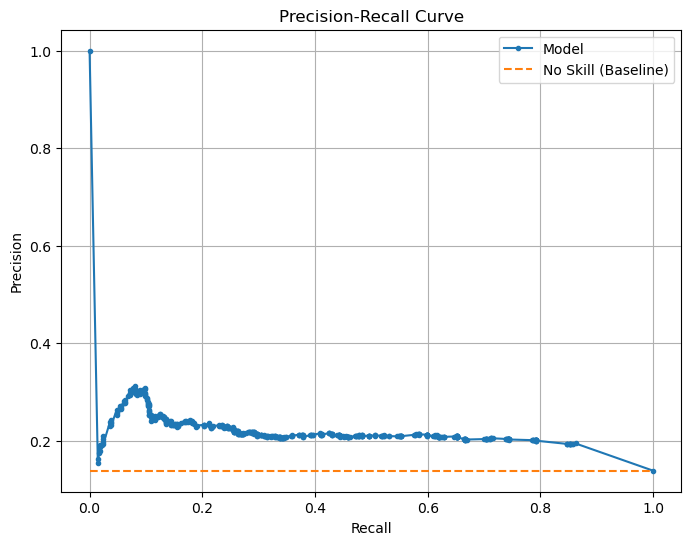

In [557]:
no_skill = y_test.mean()

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='Model')
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill (Baseline)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

##### It doesn't look like we can do much better with things as they are!

### Let's try other classifiers...

In [558]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [559]:
#model = RandomForestClassifier(class_weight='balanced')

In [560]:
pipeline = Pipeline([
    ('resample', SMOTEENN()),  #SMOTE + ENN (Edited Nearest Neighbors)
    ('model', GradientBoostingClassifier())
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('resample', SMOTEENN()),
                ('model', GradientBoostingClassifier())])

In [561]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1311 1275]
 [  81  333]]
              precision    recall  f1-score   support

           0       0.94      0.51      0.66      2586
           1       0.21      0.80      0.33       414

    accuracy                           0.55      3000
   macro avg       0.57      0.66      0.49      3000
weighted avg       0.84      0.55      0.61      3000



#### The recall for adopted users (class 1) is now very high at 0.82, which means we're successfully identifying most of the adopted users.

#### However, the precision for class 1 is still very low at 0.21, which means most predictions for adoption are false positives.

#### So doing better better, but still misclassifying many non-adopted users as adopted.

# So based on what I've found, here are the top features that help predict use adoption

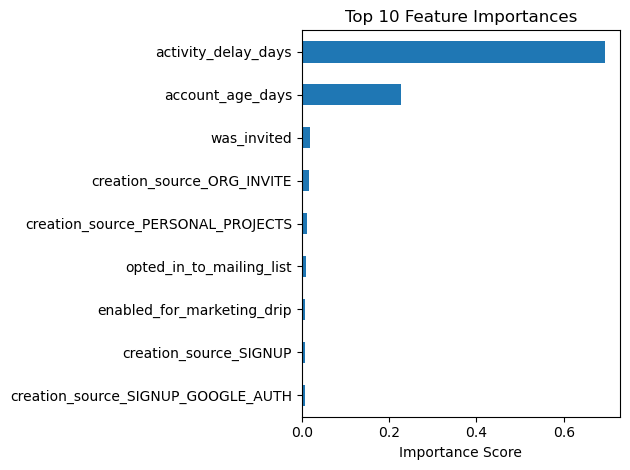

In [562]:
importances = pipeline.named_steps['model'].feature_importances_
feature_names = X_train.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

feat_imp.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

## Let's look at the ROC curve

In [563]:
X = takehome[features.columns].fillna(0)
y = takehome['adopted']

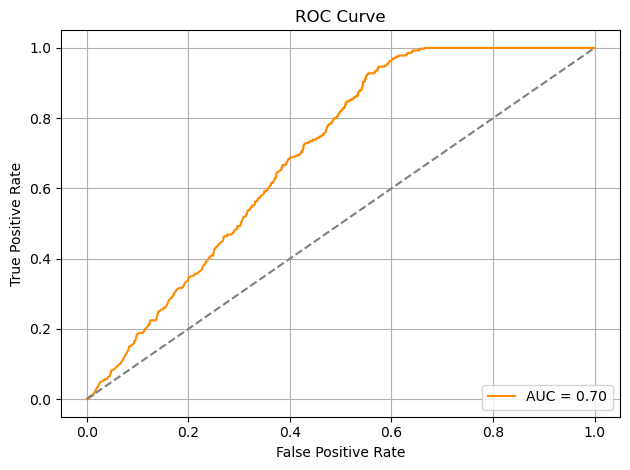

In [564]:
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

auc_score = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## So we're doing well, but there is still room for improvement

### I'm going to try using RandomOverSampler + XGBoost

In [565]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

pipeline_xgb = Pipeline([
    ('resample', RandomOverSampler()),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1))
])

pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)

print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Results:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      2586
           1       0.22      0.56      0.31       414

    accuracy                           0.66      3000
   macro avg       0.56      0.62      0.54      3000
weighted avg       0.81      0.66      0.71      3000



C:\Users\emcdo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:55:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


#### Precision for class 1 is still low (0.22), but recall jumped to 0.58, which is good.

### Now using RandomOverSampler + LightGBM

In [566]:
pipeline_lgbm = Pipeline([
    ('resample', RandomOverSampler()),
    ('model', LGBMClassifier(class_weight='balanced'))
])

pipeline_lgbm.fit(X_train, y_train)
y_pred_lgbm = pipeline_lgbm.predict(X_test)

print("LightGBM Results:")
print(classification_report(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 7758, number of negative: 7758
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 281
[LightGBM] [Info] Number of data points in the train set: 15516, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Results:
              precision    recall  f1-score   support

           0       0.91      0.59      0.72      2586
           1       0.20      0.65      0.31       414

    accuracy                           0.60      3000
   macro avg       0.56      0.62      0.51      3000
weighted avg       0.82      0.60      0.66      3000



### Slightly higher recall for class 1 (0.70) than XGBoost, but slightly worse precision (0.21).

#### F1-score for class 1: still 0.32, same as XGBoost.

## Trying the threshold calculations...

In [567]:
def evaluate_thresholds(y_true, y_proba, thresholds=np.arange(0.1, 0.91, 0.05), model_name='Model'):
    results = []

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        results.append({
            'Model': model_name,
            'Threshold': round(thresh, 2),
            'Precision': round(precision, 3),
            'Recall': round(recall, 3),
            'F1-Score': round(f1, 3)
        })

    return pd.DataFrame(results)

# --- XGBoost ---
y_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]
xgb_results = evaluate_thresholds(y_test, y_proba_xgb, model_name='XGBoost')

# --- LightGBM ---
y_proba_lgbm = pipeline_lgbm.predict_proba(X_test)[:, 1]
lgbm_results = evaluate_thresholds(y_test, y_proba_lgbm, model_name='LightGBM')

# --- Combine results ---
threshold_comparison = pd.concat([xgb_results, lgbm_results], ignore_index=True)

# View table sorted by best F1 for each model
print(threshold_comparison.sort_values(['Model', 'F1-Score'], ascending=[True, False]))

       Model  Threshold  Precision  Recall  F1-Score
19  LightGBM       0.20      0.203   0.964     0.335
18  LightGBM       0.15      0.202   0.973     0.334
17  LightGBM       0.10      0.200   0.983     0.333
20  LightGBM       0.25      0.202   0.935     0.332
21  LightGBM       0.30      0.201   0.896     0.329
22  LightGBM       0.35      0.202   0.857     0.327
23  LightGBM       0.40      0.204   0.809     0.325
24  LightGBM       0.45      0.199   0.734     0.314
25  LightGBM       0.50      0.203   0.650     0.310
26  LightGBM       0.55      0.203   0.546     0.296
27  LightGBM       0.60      0.202   0.406     0.270
28  LightGBM       0.65      0.208   0.287     0.242
29  LightGBM       0.70      0.222   0.169     0.192
30  LightGBM       0.75      0.272   0.089     0.135
31  LightGBM       0.80      0.379   0.027     0.050
32  LightGBM       0.85      0.500   0.007     0.014
33  LightGBM       0.90      0.000   0.000     0.000
0    XGBoost       0.10      0.202   0.954    

### The best F1 value for each is 0.334.  At that value:
#####  LightGBM Precision: 0.201, Recall: 0.973
#####  XGBoost   Precision: 0.207, Recall: 0.855

# LightGBM at a threshold of 0.15 seems the best, with almost perfect recall (that is to say, it doesn't miss hardly any positives).

### I'm going to calibrate the probabilities

In [568]:
y_proba_lgbm = pipeline_lgbm.predict_proba(X_test)[:, 1]

In [569]:
y_pred_thresh = (y_proba_lgbm >= 0.15).astype(int)

In [570]:
print("LightGBM @ Threshold 0.15")
print(classification_report(y_test, y_pred_thresh))

LightGBM @ Threshold 0.15
              precision    recall  f1-score   support

           0       0.99      0.38      0.55      2586
           1       0.20      0.97      0.33       414

    accuracy                           0.47      3000
   macro avg       0.60      0.68      0.44      3000
weighted avg       0.88      0.47      0.52      3000



In [571]:
calibrated_lgbm = CalibratedClassifierCV(pipeline_lgbm, method='sigmoid', cv=3)
calibrated_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5172, number of negative: 5172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 10344, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 5172, number of negative: 5172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 10344, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[L

CalibratedClassifierCV(cv=3,
                       estimator=Pipeline(steps=[('resample',
                                                  RandomOverSampler()),
                                                 ('model',
                                                  LGBMClassifier(class_weight='balanced'))]))

In [572]:
y_proba_calibrated = calibrated_lgbm.predict_proba(X_test)[:, 1]

In [573]:
y_pred_calibrated = (y_proba_calibrated >= 0.15).astype(int)

In [574]:
print(classification_report(y_test, y_pred_calibrated))

              precision    recall  f1-score   support

           0       0.93      0.56      0.70      2586
           1       0.21      0.73      0.33       414

    accuracy                           0.58      3000
   macro avg       0.57      0.64      0.51      3000
weighted avg       0.83      0.58      0.65      3000



## I've successfully boosted accuracy and balanced performance.  We've reduced the number of false positives significantly.